#Detectron2 (Mask R-CNN) to segment Carseats and Detect Wrinkles

**Summary**:
Wrinkles detection on a small set of images using original images (section 2) and images with the background filtered out (section 3).



**Written by**: Armand Kouyoumdjian



## 0 - Workbook preparation (imports, functions, ...)

### Preparing the environment (Note: Must restart runtime after running everything in this section)

In [ ]:
!gcc --version
!pip install labelme

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

# Install pyyaml - data serialization module
!pip install pyyaml==5.1



gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2


     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


In [ ]:
# import torch and utilities
import torch, torchvision

assert torch.__version__.startswith("1.7")
print(torch.__version__, torch.cuda.is_available())

# import common Python libraries used in the colab
import argparse
from labelme import utils
import PIL.Image,PIL.ImageDraw
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
import glob
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
import detectron2

from detectron2              import model_zoo
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.engine   import DefaultTrainer, DefaultPredictor
from detectron2.modeling import build_model

from detectron2.structures       import BoxMode
from detectron2.config           import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data             import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets    import register_coco_instances

from google.colab import drive



In [ ]:
# connection to drive
drive.mount("/content/drive/", force_remount=True)
path = "/content/drive/MyDrive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles"
#wrinkles_path = path+"/wrinkles"
os.chdir(path)
os.getcwd()

### Functions

In [ ]:
def register_datasets(dataset_name,json_file, image_directory):
    # register
    register_coco_instances(dataset_name, {}, json_file, image_directory)
    # dataset
    my_dataset = DatasetCatalog.get(dataset_name)
    # metadata
    my_dataset_metadata = MetadataCatalog.get(dataset_name)

    return my_dataset, my_dataset_metadata

In [ ]:
def get_dicts_data(directory, classes_objects = ['SEAT']):
    """function to create  a dictionary of  all  the information, to register the dataset
        - function is an alternative to labelcoco
        - for wrinkles, it detects the different categories"""
    classes = classes_objects
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 4024
        record["width"] = 3036
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            if anno['label'] in classes:
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(anno['label']),
                    "iscrowd": 0
                }
                objs.append(obj)
            else:
              continue
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts



In [ ]:
def register_datasets2(dataset_name, 
                       image_directory, 
                       classes_objects=['SEAT']):
  
    # register                    
    DatasetCatalog.register(dataset_name, 
                            lambda image_directory=image_directory: get_dicts_data(image_directory, classes_objects))

    # dataset
    my_dataset = DatasetCatalog.get(dataset_name)
    # metadata
    my_dataset_metadata = MetadataCatalog.get(dataset_name).set(thing_classes=classes_objects)

    return my_dataset, my_dataset_metadata

In [ ]:
def check_nbr_categories(dataset):
    """Prints the number & nature of objects per sample image, for one dataset"""
    for i, instance in enumerate(dataset):
        categories = [i["category_id"] for i in instance["annotations"]]
        unique_categories = np.unique(categories)
        print(f"{len(unique_categories)} unique classes in instance {i}: {categories}")

In [ ]:
def visualize_annotated_images(dataset,dataset_metadata,index_image=0):
    """Plots the image and annotations (only the ground-truth)"""
    d = dataset[index_image]
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=dataset_metadata , scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
def polygons_to_mask(img_shape, polygons):
    """converts annotations to a binary mask (numpy  array)"""
    mask = np.zeros(img_shape, dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    xy = list(map(tuple, polygons))
    PIL.ImageDraw.Draw(mask).polygon(xy=xy, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    return mask

In [ ]:
def train(train_dataset_name,pretrained_model_name, nbr_classes=1,iterations=300):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(pretrained_model_name))
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model_name)  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = iterations    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = nbr_classes
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    # Save the config --> used to load a model.pth without having to train again
    config_path = cfg.OUTPUT_DIR + "/config.yml"
    f = open(config_path, 'w')
    f.write(cfg.dump())
    f.close() 
    return trainer

In [ ]:
def inference(yaml_path, model_name="model_final.pth", threshold=0.5):
  """This loads the model, and builds a predictor
  Inference should use the config with parameters that are used in training"""

  cfg = get_cfg()
  cfg.merge_from_file(yaml_path)

  cfg.MODEL.WEIGHTS = os.path.join(os.getcwd(),model_name)  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set a custom testing threshold
  predictor = DefaultPredictor(cfg)
  return predictor

In [ ]:
def compute_iou(array1, array2):
    intersection = np.logical_and(array1,array2)
    union = np.logical_or(array1,array2)
    IOU = np.sum(intersection)/np.sum(union)
    return IOU

In [ ]:
def compute_iou_dataset(dataset, predictor):
    iou_scores = []
    start = time.time()
    for d in tqdm(dataset):    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        
        # print number of instances
        categories = [i["category_id"] for i in d["annotations"]]

        # compute iou
        annos = d.get("annotations", None) 
        masks = [x["segmentation"] for x in annos]
        pred = outputs['instances'].get_fields()['pred_masks']

        for i,obj in enumerate(categories):
          # mask of the ground truth
          mask = np.array(masks[i])
          mask = mask.reshape(int(mask.shape[1]/2),2)
          mask = polygons_to_mask(im.shape,mask)

          if i < pred.shape[0]:
              # mask of prediction
              pred_i = pred[i,:,:].cpu().numpy()
              pred_i = np.where(pred_i==False,0,255)

              # iou calculation and print
              iou = compute_iou(mask[:,:,0], pred_i)
              iou_scores.append(iou)

          else:
              iou_scores.append(0.0)
    
    end = time.time()
    print(f"Average inference time per sample: {(end-start)/len(dataset):.2f}")
    print(f"Average IOU: {np.mean(iou_scores):.2f}")
    


In [ ]:
def compute_positives_negatives(dataset, predictor):
    iou_scores = []
    start = time.time()


    TP = 0
    FP = 0
    TN = 0
    FN = 0

    start = time.time()
    for d in tqdm(dataset):
        iou_image = []    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        
        # print number of instances
        categories = [i["category_id"] for i in d["annotations"]]

        # compute iou
        annos = d.get("annotations", None) 
        masks = [x["segmentation"] for x in annos]
        pred = outputs['instances'].get_fields()['pred_masks']
        if (len(pred) and len(categories)) == 1:
            TN +=1
        else:
          for i,obj in enumerate(categories):
              # mask of the ground truth
              mask = np.array(masks[i])
              mask = mask.reshape(int(mask.shape[1]/2),2)
              mask = polygons_to_mask(im.shape,mask)

              if i < pred.shape[0]:
                  # mask of prediction
                  pred_i = pred[i,:,:].cpu().numpy()
                  pred_i = np.where(pred_i==False,0,255)

                  # iou calculation and print
                  iou = compute_iou(mask[:,:,0], pred_i)
                  if iou > 0.0:
                      TP += 1
                  else:
                      FP +=1

              else:
                  FN += 1

    end = time.time()
    avg_duration = (end-start)/len(dataset)

    results = {"TP":TP, "FP":FP, "TN":TN, "FN":FN}

    return results, avg_duration
   


**Explanation of the previous function, compute_positives_negatives()**

IOU > 0.0 
* TP: actual wrinkle detected

IOU = -1.0
* FN: actual wrinkle NOT detected

IOU = 0.0
* FP: false wrinkle detected

No Wrinkles in the image
* TN: No wrinkle predicted

In [ ]:
def build_confusion_matrix(dict_positives_negatives):
    df1 = pd.DataFrame({"Predicted Positive":[dict_positives_negatives.get("TP"),dict_positives_negatives.get("FP")]})
    df2 = pd.DataFrame({"Predicted Negative":[dict_positives_negatives.get("FN"),dict_positives_negatives.get("TN")]})
    df = pd.concat([df1,df2], axis=1)
    df = df.rename(index={0:"Actual Positive", 1:"Actual negative"})

    return df

In [ ]:
def compute_precision_recall(positives_negatives_dict, avg_time=None):
    """takes as input the dictionary output of the function "compute_positives_negatives()"""
    TP = positives_negatives_dict.get("TP")
    FP = positives_negatives_dict.get("FP")
    TN = positives_negatives_dict.get("TN")
    FN = positives_negatives_dict.get("FN")

    precision = TP/(TP + FP)
    recall = TP / (TP + FN)
    f1 = 2*(precision*recall)/(precision+recall)
    #F1  = 2*(precision + recall)/(precision*recall)
    print(f"precision: {precision:.3f}")
    print(f"recall: {recall:.3f}")
    print(f"f1 score: {f1:.3f}")
    print(f"mean inference time: {avg_time}")
    

**evaluate_and_display()**: Visualization function working for carseats

In [ ]:
def evaluate_and_display(dataset,dataset_metadata,predictor, nbr_images=1):
  for i,d in enumerate(random.sample(dataset, nbr_images)):  
      # read & predict
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      pred = outputs['instances'].get_fields()['pred_masks']
      pred = pred.reshape(pred.shape[1],pred.shape[2]).cpu().numpy()
      pred = pred.astype(int)
      
      # creating mask array
      annos = d.get("annotations", None)
      if annos:
        if "segmentation" in annos[0]:
            masks = [x["segmentation"] for x in annos]
        else:
            masks = None
      masks = np.array(masks)
      masks = masks.reshape(int(masks.shape[2]/2),2)
      mask = polygons_to_mask(im.shape,masks)
      
      # iou
      ground_truth = mask[:,:,0].astype(int)
      intersection = np.logical_and(pred,ground_truth)
      union = np.logical_or(pred,ground_truth)
      IOU = np.sum(intersection)/np.sum(union)
      
      # visualize
      v = Visualizer(im[:, :, ::-1],
                    metadata=dataset_metadata, 
                    scale=0.5, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
      )
      message = "Intersection Over Union : "+str(np.around(IOU*100,decimals = 2))+"%"
      v.draw_text(message,(500,50),color="red")
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      print("Test Image : ",i+1)
      cv2_imshow(out.get_image()[:, :, ::-1])

**visualize_predicted_images()**: Visualization function working for carseats **&** wrinkles

In [ ]:
def visualize_predicted_images(dataset, dataset_metadata, predictor, 
                               index_image=None,nbr_images=1):
    # Plots the predicted mask & computes the IOU (also works with wrinkles)
           
    # Initialize the visualizer
    d = dataset[index_image]
    im = cv2.imread(d["file_name"])

    v = Visualizer(im[:, :, ::-1],
                  metadata=dataset_metadata, 
                  scale=0.2, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    # computation
    if index_image is None:
      for d in random.sample(dataset, nbr_images):    
          outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
          
          # print number of instances
          categories = [i["category_id"] for i in d["annotations"]]
          print(f"{len(categories)-1} wrinkles to detect in this image")

          # plot
          v = Visualizer(im[:, :, ::-1],
                        metadata=dataset_metadata, 
                        scale=0.2, 
                        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
          )
          out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
          
          cv2_imshow(out.get_image()[:, :, ::-1])
    else:
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      
      # print number of instances
      categories = [i["category_id"] for i in d["annotations"]]
      print(f"{len(categories)-1} wrinkles to detect in this image")

      # compute iou
      annos = d.get("annotations", None) 
      masks = [x["segmentation"] for x in annos]
      pred = outputs['instances'].get_fields()['pred_masks']

      for i,obj in enumerate(categories):
        # mask of the ground truth
        mask = np.array(masks[i])
        mask = mask.reshape(int(mask.shape[1]/2),2)
        mask = polygons_to_mask(im.shape,mask)

        if i < pred.shape[0]:
            # mask of prediction
            pred_i = pred[i,:,:].cpu().numpy()
            pred_i = np.where(pred_i==False,0,255)

            # iou calculation and print
            iou = compute_iou(mask[:,:,0], pred_i)
            print(f" - Object {i+1}: IOU = {iou:.2f}")
            message = f" - Object {i+1}: IOU = {iou:.2f}"
            v.draw_text(message,(500,50+i*50),color="white")

        else:
            print(f" - Wrinkle {i+1} not detected.")

      
      # plot
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])



### Environment Variables

In [ ]:
#  dataset 1: only seats 
train_dataset_name = "my_dataset_train"
test_dataset_name = "my_dataset_test"
train_coco_filename = "results/train.json"
test_coco_filename = "results/test.json"

# dataset 2: seats + wrinkles
train_dataset_name1 = "my_dataset_train1"
test_dataset_name1 = "my_dataset_test1"
train_coco_filename1 = "results/train1.json"
test_coco_filename1 = "results/test1.json"


# dataset 3: seats + wrinkles + White Background 
train_dataset_name2 = "my_dataset_train2"
test_dataset_name2 = "my_dataset_test2"
train_coco_filename2 = "results/train2.json"
test_coco_filename2 = "results/test2.json"


# models
pretrained_model_mask_rcnn = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

## 1 - Segment & Detect Seats

Task already done

#### 1.1 - Registration

Note 1: 1st registration encounters problems, preferrable to use the second  ("register 2nd method")

Note 2: For error "Dataset 'my_dataset_train' is already registered!", restart the kernel and execute again

In [ ]:
# Register >> datasets >> metadata
train_dataset, train_dataset_metadata = register_datasets(dataset_name = train_dataset_name,
                                                          json_file = train_coco_filename,
                                                          image_directory = "train")

test_dataset, test_dataset_metadata = register_datasets(dataset_name = test_dataset_name,
                                                        json_file = test_coco_filename,
                                                        image_directory = "test")

In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset,train_dataset_metadata)

#### 1.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 1,
      iterations = 1000)

#### 1.3 - Inference

In [ ]:
# Build a predictor
output_path = "output_seats/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_seats/model_final.pth


In [ ]:
# Visualize the predictions on train
visualize_predicted_images(dataset = train_dataset, 
                           dataset_metadata = train_dataset_metadata, 
                           predictor = my_predictor)


In [ ]:
# visualize & evaluate on test_set
evaluate_and_display(train_dataset,train_dataset_metadata,my_predictor)


## 2 - WRINKLES 1: segment & detect wrinkles 

#### 2.1 - Registration

1st method to register a dataset with only "SEAT" and "WRINKLE"

To register a dataset with different types of wrinkles, use the second method (next cell)

In [ ]:
# # Register 1st method >> datasets >> metadata
# train_dataset1, train_dataset_metadata1 = register_datasets(dataset_name = train_dataset_name1,
#                                                           json_file = train_coco_filename1,
#                                                           image_directory = "train1")

# test_dataset1, test_dataset_metadata1 = register_datasets(dataset_name = test_dataset_name1,
#                                                           json_file = test_coco_filename1,
#                                                           image_directory = "test1")

In [ ]:
# # register 2nd method >> datasets >> metadata
objects_list= ['SEAT', 'WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']
#objects_list= ['WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']


train_dataset1, train_dataset_metadata1 = register_datasets2(dataset_name = train_dataset_name1, 
                                                             image_directory="train1", 
                                                             classes_objects=objects_list)
  
test_dataset1, test_dataset_metadata1 = register_datasets2(dataset_name = test_dataset_name1, 
                                                           image_directory="test1", 
                                                           classes_objects=objects_list)
  

In [ ]:
# check if the algorithm recognized that there were different wrinkles
check_nbr_categories(test_dataset1)

2 unique classes in instance 0: [0, 1]
3 unique classes in instance 1: [0, 1, 2]
3 unique classes in instance 2: [0, 1, 2, 1, 1]
3 unique classes in instance 3: [0, 1, 1, 2, 2, 1]
2 unique classes in instance 4: [0, 1, 1, 1]
3 unique classes in instance 5: [0, 2, 1, 1, 1]


In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset1,train_dataset_metadata1)

#### 2.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name1, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 3,
      iterations = 1000)

#### 2.3 - Inference

#####**Results for model trained on 2 instances**:

1. SEAT
2. WRINKLE

In [ ]:
# Build a predictor
output_path = "output_wrinkles1/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1/model_final.pth


In [ ]:
# inference: Positives & Negatives ...
results_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test = compute_positives_negatives(test_dataset1, my_predictor)


/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train)
print("\nTest set")
compute_precision_recall(results_test)

,Predicted Positive,Predicted Negative
Actual Positive,41,16
Actual negative,60,2


,Predicted Positive,Predicted Negative
Actual Positive,10,7
Actual negative,8,0


Train set
precision: 0.406
recall: 0.719

Test set
precision: 0.556
recall: 0.588


#####**Results for model trained on set, with 4 instances**:
1.  SEAT
2.  WRINKLE_1
3.  WRINKLE_2
4.  WRINKLE_3


In [ ]:
# Build a predictor
output_path = "output_wrinkles1_differentwrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.6)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1_differentwrinkles/model_final.pth


In [ ]:
# Visualize the predictions on test set
visualize_predicted_images(dataset = test_dataset1, 
                           dataset_metadata = test_dataset_metadata1, 
                           predictor = my_predictor,
                           index_image=np.random.randint(len(test_dataset1)-1))

In [ ]:
# inference: Positives & Negatives ...
results_train, avg_time_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test,avg_time_test = compute_positives_negatives(test_dataset1, my_predictor)


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("train set")
compute_precision_recall(results_train, avg_time_train)
print("\ntest set ")
compute_precision_recall(results_test, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,25,89
Actual negative,3,2


,Predicted Positive,Predicted Negative
Actual Positive,6,19
Actual negative,0,0


train set
precision: 0.893
recall: 0.219
f1 score: 0.352
mean inference time: 0.7178725302219391

test set 
precision: 1.000
recall: 0.240
f1 score: 0.387
mean inference time: 0.6754646698633829


#####**Results for model trained on set, with 3 instances**:
1. Wrinkle 1
2. Wrinkle 2
3. Wrinkle 3



In [ ]:
# Build a predictor
output_path = "output_wrinkles1_onlywrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.2)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1_onlywrinkles/model_final.pth


In [ ]:
# inference: Positives & Negatives ...
results_train, avg_time_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test, avg_time_test = compute_positives_negatives(test_dataset1, my_predictor)


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("\ntrain set")
compute_precision_recall(results_train, avg_time_train)
print("\ntest set ")
compute_precision_recall(results_test, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,21,1
Actual negative,73,0


,Predicted Positive,Predicted Negative
Actual Positive,6,0
Actual negative,12,1



train set
precision: 0.223
recall: 0.955
f1 score: 0.362
mean inference time: 1.0687576433022816

test set 
precision: 0.333
recall: 1.000
f1 score: 0.500
mean inference time: 0.8968468904495239


## 3 - WRINKLES 2: segment & detect wrinkles (background whitened)

#### 3.1 - Registration


In [ ]:
# list of objects
objects_list = ['SEAT', 'WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']


In [ ]:
# register 2nd method >> datasets >> metadata
train_dataset2, train_dataset_metadata2 = register_datasets2(dataset_name = train_dataset_name2, 
                       image_directory="train2", 
                       classes_objects=objects_list)
  
test_dataset2, test_dataset_metadata2 = register_datasets2(dataset_name = test_dataset_name2, 
                       image_directory="test2", 
                       classes_objects=objects_list)
  

In [ ]:
check_nbr_categories(train_dataset2)

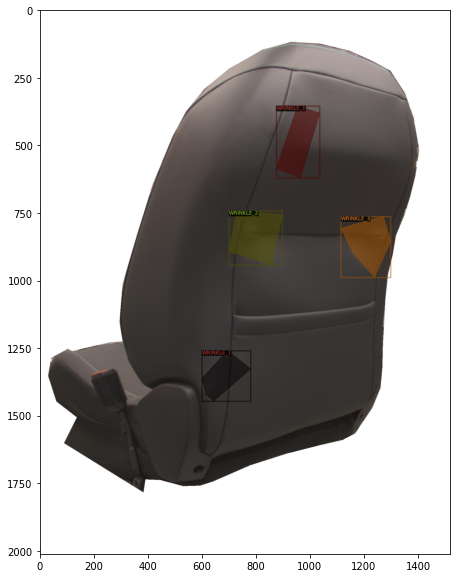

In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset2,
                           train_dataset_metadata2)

#### 3.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name2, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 3,
      iterations = 1000)

#### 3.3 - Inference

#####**Model trained on 2 instances**:
1. Seat
2. Wrinkle

In [ ]:
# Build a predictor
output_path = "output_nobackground_wrinkles_1/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_wrinkles_1/model_final.pth


In [ ]:
# Visualize the predictions on train
visualize_predicted_images(dataset = train_dataset2, 
                           dataset_metadata = train_dataset_metadata2, 
                           predictor = my_predictor,
                           index_image=0,
                           nbr_images=1)
# test set
for i, image in enumerate(test_dataset2):
    visualize_predicted_images(dataset = test_dataset2, 
                           dataset_metadata = test_dataset_metadata2, 
                           predictor = my_predictor,
                           index_image=i)

In [ ]:
compute_iou_dataset(train_dataset2, 
                    my_predictor)


Average inference time per sample: 1.18
Average IOU: 0.26


In [ ]:
compute_iou_dataset(test_dataset2, 
                    my_predictor)


Average inference time per sample: 1.06
Average IOU: 0.27


Computing the precision and recall on the train set

In [ ]:
# inference: True positives, False positives, ...
results_train2 = compute_positives_negatives(train_dataset2, my_predictor)
results_test2 = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train2)
print("\nTest set")
compute_precision_recall(results_test2)

,Predicted Positive,Predicted Negative
Actual Positive,39,40
Actual negative,38,2


,Predicted Positive,Predicted Negative
Actual Positive,9,10
Actual negative,6,0


Train set
precision: 0.506
recall: 0.494

Test set
precision: 0.600
recall: 0.474


#####**Model trained on 4 instances**:
1. Seat
2. Wrinkle_1
3. Wrinkle_2
4. Wrinkle_3


In [ ]:
# Build a predictor
output_path = "output_nobackground_differentwrinklescategories/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.6)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_differentwrinklescategories/model_final.pth


In [ ]:
# inference: True positives, False positives, ...
results_train2,avg_time_train = compute_positives_negatives(train_dataset2, my_predictor)
results_test2,avg_time_test = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train2, avg_time_train)
print("\nTest set")
compute_precision_recall(results_test2, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,24,92
Actual negative,1,2


,Predicted Positive,Predicted Negative
Actual Positive,6,19
Actual negative,0,0


Train set
precision: 0.960
recall: 0.207
f1 score: 0.340
mean inference time: 0.663681834936142

Test set
precision: 1.000
recall: 0.240
f1 score: 0.387
mean inference time: 0.6190698146820068


#####**Model trained on 3 instances**:

2. Wrinkle_1
3. Wrinkle_2
4. Wrinkle_3


In [ ]:
# Build a predictor
output_path = "output_nobackground_onlywrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.2)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_onlywrinkles/model_final.pth


In [ ]:
# inference: True positives, False positives, ...
results_train2, avg_time_train = compute_positives_negatives(train_dataset2, my_predictor)
results_test2, avg_time_test = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("\nTrain set")
compute_precision_recall(results_train2, avg_time_train)
print("\nTest set")
compute_precision_recall(results_test2, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,32,0
Actual negative,62,1


,Predicted Positive,Predicted Negative
Actual Positive,5,6
Actual negative,7,1



Train set
precision: 0.340
recall: 1.000
f1 score: 0.508
mean inference time: 0.9934171537558237

Test set
precision: 0.417
recall: 0.455
f1 score: 0.435
mean inference time: 0.717857837677002
